$$
\DeclareMathOperator{\dexp}{dexp}
\DeclareMathOperator{\ad}{ad}
$$

# Quantum Dynamics Simulation

A quantum computer is typically implemented via a set of controllable Hamiltonians. E.g.:

$$
H(t) = H_d + \sum_k a_k(t) H_k
$$
where $H_d$ is a drift Hamiltonian, $H_k$ are a set on controllable (typically 2 to 3) Hamiltonians that are scaled by time-dependent parameter $a_k(t)$. The goal is to find $a_k(t)$ such that the system is driven to a desired unitary. The problem can be framed as a non-linear optimization problem by using the gradients (of error) of the time-evolution to find minima. Hence, the time-dependent Schrödinger equation needs to be solved, and the gradients of error for each $a_k(t)$ need to be computed. In this chapter we look into the first part: how to solve the time-dependent Schrödinger equation.

## The Objective

We want to find the propagator $U(t, t_0)$ that connects the quantum state at different times,

$$
\ket{\psi(t)} = U(t, t_0)\ket{\psi(t_0)}.
$$

The solution is often writen as

$$
U(t, t_0)=\mathcal T\exp\left[-i\int_{t_0}^tH(\tau)d\tau\right]
$$

where $\mathcal T$ is the time-ordering operator (see also [Dyson series](https://en.wikipedia.org/wiki/Dyson_series)). But how does one numerically solve this? The standard treatment is to discretize the integrals as Riemann sums

$$
U(t)\approx\prod_{a=0}^{k-1}\exp[-iH(a\Delta\tau)\Delta\tau]~~~~(\Delta\tau=t/k)
$$ (eq: riemann)

```{note}
Although this method is used in simulating quantum systems on classical computers, this technique is also commonly found in quantum computing literature with regards to implementating an operator $U(t)$ as a quantum algorithm.
```

Equation {eq}`eq: riemann` has given us a way to compute the propogator. However, a straightfoward analysis of this equation will show that the expansion is not unitary when truncated to finite order. Is this a better strategy to solve the time-dependent equation?


The following walks through the Magnus expansion, and solving the time-dependent Schrödinger equation when $H$ does not commute with itself at different times, i.e. when $[H(t_1), H(t_2)] \neq 0$. The Magnus expansion conserves phase-space relationships. This means that energy is conserved even for long-time dynamics, where as other methods begin to fail -- and thus the result remains unitary even when truncated.

For a thorough review: [arXiv:0810.5488](https://arxiv.org/abs/0810.5488)

## Magnus Expansion

Consider the linear differential equation of the form

$$
\begin{equation}
Y^\prime(t) = H(t) Y(t);\quad Y(0) = Y_0
\end{equation}
$$ (eq: og)

whose solution can be expressed as

$$
\begin{equation}\label{eq: sol}
Y(t) = \exp(\Omega(t))Y_0
\end{equation}
$$ (eq: sol)

where the difficulty lies in finding $\Omega(t)$. Differentiating {eq}`eq: sol` results in:

$$
\begin{equation}\label{eq: expansion}
    Y^\prime(t) = {d\over dt}\exp(\Omega(t))Y_0 = \dexp_{\Omega(t)}(\Omega^\prime(t))\exp(\Omega(t))Y_0
\end{equation}
$$ (eq: expansion)

where the derivative of the exponential map $\dexp$ is defined as

$$
\begin{equation}
    \dexp_\Omega(C) = \sum_{i=0}^\infty \frac{1}{(i + 1)!}\ad_\Omega^i (C)
\end{equation}
$$

The operator $\ad_\Omega^i(C)$ is the iterated commutator and recursively defined as:

$$
\ad_\Omega^i (C) = [\Omega, \ad_\Omega^{i-1}(C)], \quad i\ge 1
$$

Combining {eq}`eq: og` and {eq}`eq: expansion` leads to

$$
\begin{equation}
    H(t) = \dexp_{\Omega(t)} (\Omega^\prime(t)), \quad \Omega(0) = 0
\end{equation}
$$

The inverse of the derivative of the exponential map will give

$$
\begin{equation}
    \Omega^\prime(t) = \dexp_{\Omega(t)}^{-1} (A(t))
\end{equation}
$$

which is given by

$$
\begin{equation}
    \dexp_\Omega^{-1}(A) = \sum_{i=0}^\infty \frac{B_k}{k!}\ad_\Omega^i(A).
\end{equation}
$$

Here $B_k$ are the Bernoulli numbers. The series converges only if 

$$
\begin{equation}
    \int_0^t ||H(s)||_2 ds < \pi
\end{equation}
$$

By applying Picard's Iteration, one gets an infinite series for $\Omega(t)$:

$$
\begin{equation}
    \Omega(t) = \sum_{k=1}^\infty \Omega_k(t)
\end{equation}
$$

Where the first terms are:

$$
    \begin{align}
        \Omega_1(t) &= \int_0^t H(t_1) dt_1\\
        \Omega_2(t) &= \frac{1}{2}\int_0^t dt_1 \int_0^{t_1} dt_2 [H(t_1), H(t_2)]\\
        \Omega_3(t) &= \frac{1}{6}\int_0^t dt_1 \int_0^{t_1} dt_2 \int_0^{t_2} dt_3 ([H(t_1), [H(t_2), H(t_3)]] + [H(t_3), [H(t_2), H(t_1)]])\\
    \end{align}
$$

Each subsequent order in the Magnus expansion is a correction that accounts for the proper time-ordering of the Hamiltonian.


## Numerical Calculation

Assume a constant time step of size $\Delta t$, thus the solution after one time step is

$$
\begin{equation}
    Y(t_n + \delta t) = \exp(\Omega(t_n + \delta t)) Y(t_n)
\end{equation}
$$

and hence

$$
\begin{equation}
    Y_{n+1} = \exp(\Omega_n) Y_n
\end{equation}
$$

### First Order

To begin, truncate the series leaving only the first term, and approximate the integral with a Riemann sum. Hence,

$$
\Omega_n(\Delta t) = \Delta t H\left(t_n\right)
$$

as an approximation for $\Omega(t_n + \Delta t)$

So the full approximation is

$$
Y_{n+1} = \exp(\Delta t H\left(t_n\right)) Y_n
$$

### Second Order

Truncate the series to the second term. Approximate the integral with a Gauss Quadrature. The approximation is then

$$
Y_{n+1} = \exp(\frac{\Delta t}{2}(A_1 + A_2) + \frac{\sqrt{3}\Delta t^2}{12}[A_2, A_1]) Y_n
$$

where $A_1 = A(t_n + c_- \Delta t)$ and $A_2 = A(t_n + c_+ \Delta t)$ with $c_\pm = \frac{1}{2}\pm \frac{\sqrt{3}}{6}$.


## Python Example 

As an example, let us simulate a simple quantum system

$$
H(t) = a(t)\sigma_x + a(t)\sigma_y
$$

where $a(t)$ is a Gaussian pulse. Particulary, we wish to see how the system involves in time. Let us also compare with the simulation performed by `qutip`.

In [14]:
import numpy as np
import qutip as qp
from scipy.linalg import expm
import matplotlib.pyplot as plt

In [15]:
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, 1j], [-1j, 0]])

print(X)
print(Y)

[[0 1]
 [1 0]]
[[ 0.+0.j  0.+1.j]
 [-0.-1.j  0.+0.j]]


### Create the pulse

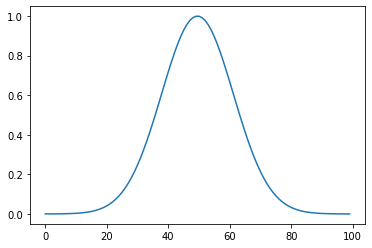

In [27]:
t_r = np.linspace(0, 40, 100)

x = np.linspace(-3, 3, len(t_r))
pulse = np.exp(-x**2)
plt.plot(pulse)

plt.show()

### Use QuTip to solve the evolution

In [17]:
H_qp = [[qp.Qobj(X), pulse], [qp.Qobj(Y), pulse]]
# H_qp = qp.Qobj(X)
psi = qp.basis(2,0)
result = qp.sesolve(H_qp, psi, t_r)

### Use First-order Magnus Expansion

In [18]:
dt = t_r[1] - t_r[0]
dt

0.40404040404040403

In [19]:
psi_history = []

psi = np.array([[1], [0]])

for i in range(len(t_r)):
    Omega = dt * (pulse[i] * X + pulse[i] * Y)
    prop = expm(-1j * Omega)
    psi_history.append(psi)
    psi = prop @ psi

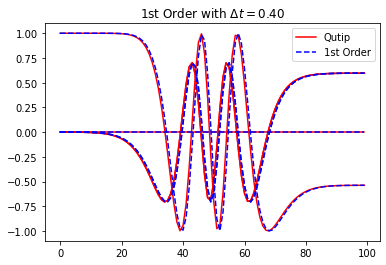

In [26]:
qp_evolution = np.array([s.full() for s in result.states])
magnus_1_evolution = np.array(psi_history)

plt.plot(qp_evolution[:, 0].real, color='r', label='Qutip')
plt.plot(qp_evolution[:, 0].imag, color='r')
plt.plot(qp_evolution[:, 1].real, color='r')
plt.plot(qp_evolution[:, 1].imag, color='r')

plt.plot(magnus_1_evolution[:, 0].real, '--', color='b', label='1st Order')
plt.plot(magnus_1_evolution[:, 0].imag, '--', color='b')
plt.plot(magnus_1_evolution[:, 1].real, '--', color='b')
plt.plot(magnus_1_evolution[:, 1].imag, '--', color='b')

plt.legend()

plt.title(r"1st Order with $\Delta t = {:.2f}$".format(dt))

plt.plot();

### Use two-stage Gauss quadrature for second order

In [21]:
psi_history_2 = []

psi = np.array([[1], [0]])

c_1 = 0.5 - np.sqrt(3)/6
c_2 = 0.5 + np.sqrt(3)/6

def commu(A,B):
    return A@B - B@A

for i in range(len(t_r)):
    t_1 = x[i] + (c_1 * dt)
    t_2 = x[i] + c_2 * dt

    A_1 = np.exp(-t_1**2) * X + np.exp(-t_1**2) * Y
    A_2 = np.exp(-t_2**2) * X + np.exp(-t_2**2) * Y
    Omega = dt/2 * (A_1 + A_2) + np.sqrt(3)*dt**2 / 12 * commu(A_2, A_1)

    prop = expm(-1j * Omega)
    psi_history_2.append(psi)
    psi = prop @ psi

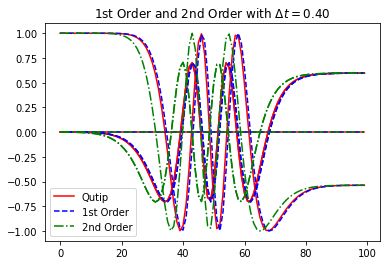

In [28]:
magnus_2_evolution = np.array(psi_history_2)

plt.plot(qp_evolution[:, 0].real, color='r', label='Qutip')
plt.plot(qp_evolution[:, 0].imag, color='r')
plt.plot(qp_evolution[:, 1].real, color='r')
plt.plot(qp_evolution[:, 1].imag, color='r')

plt.plot(magnus_1_evolution[:, 0].real, '--', color='b', label='1st Order')
plt.plot(magnus_1_evolution[:, 0].imag, '--', color='b')
plt.plot(magnus_1_evolution[:, 1].real, '--', color='b')
plt.plot(magnus_1_evolution[:, 1].imag, '--', color='b')

plt.plot(magnus_2_evolution[:, 0].real, '-.', color='g', label='2nd Order')
plt.plot(magnus_2_evolution[:, 0].imag, '-.', color='g')
plt.plot(magnus_2_evolution[:, 1].real, '-.', color='g')
plt.plot(magnus_2_evolution[:, 1].imag, '-.', color='g')

plt.legend()

plt.title(r"1st Order and 2nd Order with $\Delta t = {:.2f}$".format(dt))

plt.show()